In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Make NumPy values easier to read
np.set_printoptions(precision=3, suppress=True)

In [2]:
titanic = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [3]:
titanic_features = titanic.copy()
titanic_labels = titanic_features.pop('survived')

The first step is to match names and data-types of the CSV columns

In [6]:
inputs = {}

for name, column in titanic_features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32
  
  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'age': <tf.Tensor 'age:0' shape=(None, 1) dtype=float32>,
 'alone': <tf.Tensor 'alone:0' shape=(None, 1) dtype=string>,
 'class': <tf.Tensor 'class:0' shape=(None, 1) dtype=string>,
 'deck': <tf.Tensor 'deck:0' shape=(None, 1) dtype=string>,
 'embark_town': <tf.Tensor 'embark_town:0' shape=(None, 1) dtype=string>,
 'fare': <tf.Tensor 'fare:0' shape=(None, 1) dtype=float32>,
 'n_siblings_spouses': <tf.Tensor 'n_siblings_spouses:0' shape=(None, 1) dtype=float32>,
 'parch': <tf.Tensor 'parch:0' shape=(None, 1) dtype=float32>,
 'sex': <tf.Tensor 'sex:0' shape=(None, 1) dtype=string>}

In [8]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}
x = keras.layers.Concatenate()(list(numeric_inputs.values()))
norm = keras.layers.experimental.preprocessing.Normalization()
norm.adapt(np.array(titanic[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<tf.Tensor 'normalization/truediv:0' shape=(None, 4) dtype=float32>

In [9]:
preprocessed_inputs = [all_numeric_inputs]

Next convert all string into numbers

In [11]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue
  lookup = keras.layers.experimental.preprocessing.StringLookup(
      vocabulary=np.unique(titanic_features[name])
  )
  one_hot = keras.layers.experimental.preprocessing.CategoryEncoding(
      max_tokens=lookup.vocab_size()
  )

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

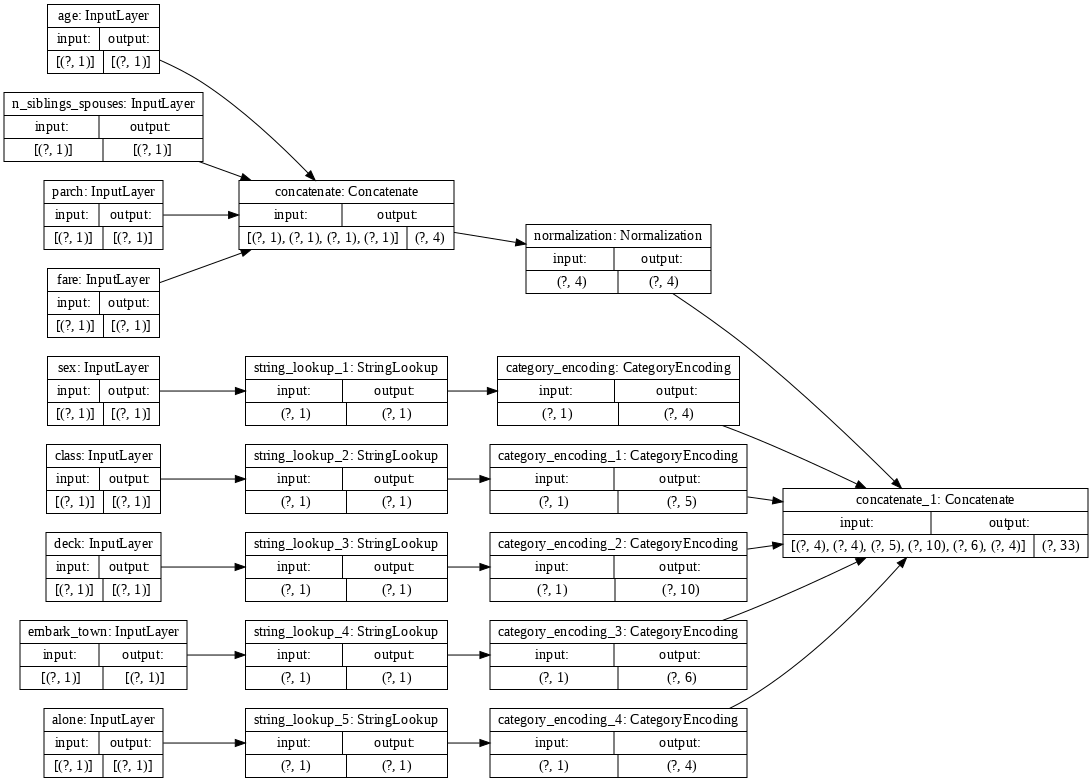

In [12]:
preprocessed_inputs_cat = keras.layers.Concatenate()(preprocessed_inputs)
titanic_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)
keras.utils.plot_model(model=titanic_preprocessing, rankdir="LR", dpi=72, 
                       show_shapes=True)

In [13]:
# Convert into np.array
titanic_features_dict = {name: np.array(value) 
                         for name, value in titanic_features.items()}

In [14]:
features_dict = {name:values[:1] for name, values in titanic_features_dict.items()}
titanic_preprocessing(features_dict)

<tf.Tensor: shape=(1, 33), dtype=float32, numpy=
array([[-0.61 ,  0.395, -0.479, -0.497,  0.   ,  0.   ,  0.   ,  1.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  1.   ,
         0.   ]], dtype=float32)>

In [15]:
def titanic_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    keras.layers.Dense(64),
    keras.layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = keras.Model(inputs, result)

  model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.optimizers.Adam())
  
  return model

titanic_model = titanic_model(titanic_preprocessing, inputs)

In [16]:
titanic_model.fit(x=titanic_features_dict, y=titanic_labels, epochs=10)

Epoch 1/10
20/20 [==============================] - 0s 1ms/step - loss: 0.5685
Epoch 2/10
20/20 [==============================] - 0s 1ms/step - loss: 0.5017
Epoch 3/10
20/20 [==============================] - 0s 2ms/step - loss: 0.4676
Epoch 4/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4495
Epoch 5/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4358
Epoch 6/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4303
Epoch 7/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4251
Epoch 8/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4225
Epoch 9/10
20/20 [==============================] - 0s 2ms/step - loss: 0.4212
Epoch 10/10
20/20 [==============================] - 0s 2ms/step - loss: 0.4207
